# 4.- Train

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
df = pd.read_csv("../data/processed/features.csv").drop(['Date'], axis=1)
df

,Abs Extrema Duration,Low Threshold Count,Max Between Min,Pattern Extrema Duration,Min Deviation,Min Mean,Label
0,0.700000,0.033333,False,0.100000,0.383745,0.262343,0.0
1,0.366667,0.033333,False,0.200000,0.483459,0.382396,0.0
2,0.700000,0.066667,True,0.066667,0.012333,0.008721,1.0
3,0.466667,0.066667,True,0.133333,0.385687,0.087807,0.0
4,0.566667,0.000000,False,0.066667,0.083906,0.480007,0.0
...,...,...,...,...,...,...,...
98,0.466667,0.066667,True,0.100000,0.318943,0.047218,1.0
99,0.566667,0.033333,False,0.066667,0.338186,0.149486,1.0
100,0.733333,0.033333,False,0.133333,0.282234,0.105815,0.0
101,0.166667,0.100000,True,0.233333,0.272872,0.009114,1.0


## Split Data

In [3]:
label_df = df['Label']
features_df = df.drop('Label', axis=1)
features_df

,Abs Extrema Duration,Low Threshold Count,Max Between Min,Pattern Extrema Duration,Min Deviation,Min Mean
0,0.700000,0.033333,False,0.100000,0.383745,0.262343
1,0.366667,0.033333,False,0.200000,0.483459,0.382396
2,0.700000,0.066667,True,0.066667,0.012333,0.008721
3,0.466667,0.066667,True,0.133333,0.385687,0.087807
4,0.566667,0.000000,False,0.066667,0.083906,0.480007
...,...,...,...,...,...,...
98,0.466667,0.066667,True,0.100000,0.318943,0.047218
99,0.566667,0.033333,False,0.066667,0.338186,0.149486
100,0.733333,0.033333,False,0.133333,0.282234,0.105815
101,0.166667,0.100000,True,0.233333,0.272872,0.009114


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_df,
                                                    label_df,
                                                    test_size=0.3,
                                                    stratify=df['Label'])

## Define Hyperparameters

In [ ]:
scalers = [StandardScaler(), MinMaxScaler(), 'passthrough']

param_grid = [
    {
        'scaler': scalers,
        'model': [RandomForestClassifier()],
        'model__n_estimators': [100, 200, 500],
        'model__max_depth': [5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    {
        'scaler': scalers,
        'model': [GradientBoostingClassifier()],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7],
    },
    {
        'scaler': scalers,
        'model': [SVC()],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
    }
]

pipeline = Pipeline([
    ('scaler', 'passthrough'),
    ('model', RandomForestClassifier())
])

cv_options = [3, 5, 7]
all_results = []
summary_results = []

## GridSearch Fitting

In [ ]:
for cv_splits in cv_options:
    print(f"\nRunning GridSearchCV with {cv_splits}-fold cross-validation...")
    
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=cv_splits, shuffle=True),
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    grid_search.fit(X_train, y_train)
    
    cv_results_df = pd.DataFrame(grid_search.cv_results_)
    cv_results_df['cv_splits'] = cv_splits
    all_results.append(cv_results_df)
    
    best_index = grid_search.best_index_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best Parameters (CV={cv_splits}): {best_params}")
    print(f"Best Cross-Validation Score (CV={cv_splits}): {best_score}")
    
    summary_results.append({
        'cv_splits': cv_splits,
        'best_params': best_params,
        'train_score' : grid_search.cv_results_[
            'mean_train_score'][best_index],
        'validation_score' : grid_search.cv_results_[
            'mean_test_score'][best_index],
        'best_score': best_score,
        'scaler': best_params['scaler'],
        'best_model': grid_search.best_estimator_.named_steps[
            'model'],
        'best_scaler' : grid_search.best_estimator_.named_steps[
            'scaler']
    })

all_results_df = pd.concat(all_results, ignore_index=True)
summary_results_df = pd.DataFrame(summary_results)


Running GridSearchCV with 3-fold cross-validation...
Fitting 3 folds for each of 315 candidates, totalling 945 fits
Best Parameters (CV=3): {'model': RandomForestClassifier(), 'model__max_depth': 5, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 100, 'scaler': MinMaxScaler()}
Best Cross-Validation Score (CV=3): 0.75

Running GridSearchCV with 5-fold cross-validation...
Fitting 5 folds for each of 315 candidates, totalling 1575 fits
Best Parameters (CV=5): {'model': RandomForestClassifier(), 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 100, 'scaler': StandardScaler()}
Best Cross-Validation Score (CV=5): 0.7666666666666667

Running GridSearchCV with 7-fold cross-validation...
Fitting 7 folds for each of 315 candidates, totalling 2205 fits
Best Parameters (CV=7): {'model': GradientBoostingClassifier(), 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200, 'scaler':

In [ ]:
print("\nSummary of Best Results:")
summary_results_df


Summary of Best Results:


,cv_splits,best_params,train_score,validation_score,best_score,scaler,best_model,best_scaler
0,3,"{'model': RandomForestClassifier(), 'model__ma...",0.951389,0.722222,0.722222,StandardScaler(),"(DecisionTreeClassifier(max_depth=10, max_feat...",NaN
1,5,"{'model': RandomForestClassifier(), 'model__ma...",0.829885,0.754286,0.754286,passthrough,"(DecisionTreeClassifier(max_depth=5, max_featu...",NaN
2,3,"{'model': RandomForestClassifier(), 'model__ma...",0.930556,0.750000,0.750000,MinMaxScaler(),"(DecisionTreeClassifier(max_depth=5, max_featu...",MinMaxScaler()
3,5,"{'model': RandomForestClassifier(), 'model__ma...",0.833454,0.766667,0.766667,StandardScaler(),"(DecisionTreeClassifier(max_depth=5, max_featu...",StandardScaler()
4,7,"{'model': GradientBoostingClassifier(), 'model...",1.000000,0.725974,0.725974,passthrough,([DecisionTreeRegressor(criterion='friedman_ms...,passthrough


In [ ]:
best_overall_result = summary_results_df.loc[
    summary_results_df['best_score'].idxmax()]

best_model = best_overall_result['best_model']

print("\nBest Overall Configuration:")
print(best_overall_result['best_params'])
best_overall_result


Best Overall Configuration:
{'model': RandomForestClassifier(), 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 100, 'scaler': StandardScaler()}


cv_splits                                                           5
best_params         {'model': RandomForestClassifier(), 'model__ma...
train_score                                                  0.833454
validation_score                                             0.766667
best_score                                                   0.766667
scaler                                               StandardScaler()
best_model          (DecisionTreeClassifier(max_depth=5, max_featu...
best_scaler                                          StandardScaler()
Name: 3, dtype: object

**Observations**

- Gap between training and validation:

There is a 6.67% difference between the training and validation score (0.833 - 0.767).

This difference indicates that the model generalizes relatively well but presents a slight overfitting.

- Random Forest regularization:

The adjusted parameters such as *max_depth=5* and *min_samples_leaf=4* introduce regularization, controlling the complexity of the trees and avoiding excessive splits. This may explain the good balance between training and validation performance.

- Scaler usage:

Although Random Forest are not sensitive to data scale (due to their nature based on splitting thresholds), the use of *StandardScaler* could have benefited other features or models in your hyperparameter search.

In this case, it does not negatively affect performance, but it is also not a critical requirement for Random Forest.

## Model Evaluation and Performance Metrics

In [26]:
X_test_scaled = best_overall_result['best_scaler'].transform(X_test)
y_pred = best_model.predict(X_test_scaled)

Accuracy on test set: 0.9032

Classification Report:
               precision    recall  f1-score   support

   No Pattern       1.00      0.81      0.90        16
Double Bottom       0.83      1.00      0.91        15

     accuracy                           0.90        31
    macro avg       0.92      0.91      0.90        31
 weighted avg       0.92      0.90      0.90        31



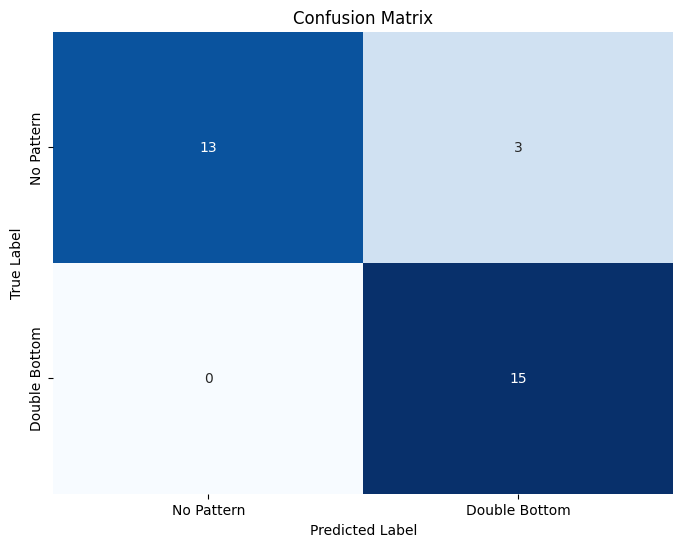

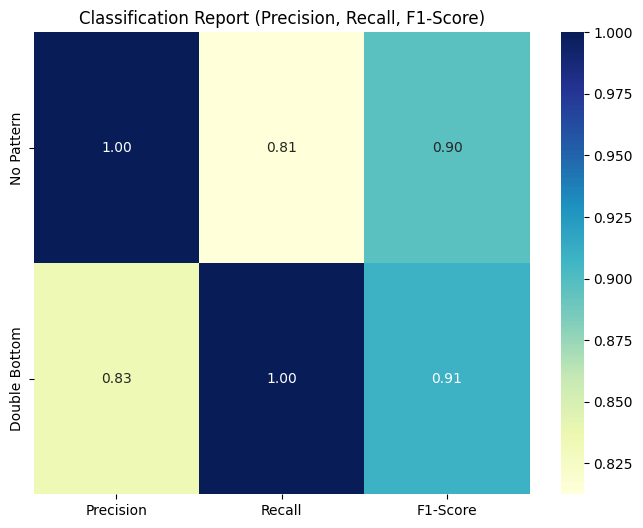

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(
    y_test, y_pred,
    target_names=['No Pattern',
                  'Double Bottom'])
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy on test set: {accuracy:.4f}")
print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True,
            fmt='d', cmap='Blues',
            cbar=False,
            xticklabels=['No Pattern', 'Double Bottom'],
            yticklabels=['No Pattern', 'Double Bottom'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

report_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=['No Pattern', 'Double Bottom'])

plt.figure(figsize=(8, 6))
sns.heatmap(report_df, annot=True, cmap="YlGnBu", cbar=True, fmt='.2f')
plt.title("Classification Report (Precision, Recall, F1-Score)")
plt.show()

**Observations**

- Precision:

*No Pattern (1.00)*: The model made no errors in predicting this class; that is, when it predicts “No Pattern,” it is confident.

*Double Bottom (0.83)*: Some cases were predicted as “Double Bottom” incorrectly, indicating false positives.

- Recall:

*No Pattern (0.81)*: The model missed 19% of the actual “No Pattern” cases, indicating false negatives.

*Double Bottom (1.00)*: The model identified all true cases of “Double Bottom”, which is a strength.

- F1-Score:

Both classes have values close to 0.90, reflecting good overall performance.

- Support:

16 samples for “No Pattern” and 15 samples for “Double Bottom.” The model handles both classes well, although they are slightly unbalanced.

**Conclusions**

- Good overall performance:

With an accuracy of 90.32% and F1-scores close to 0.90 in both classes, the model performs robustly on the test set.

- Class “No Pattern” has false negatives:

Although the accuracy is perfect, the recall of 0.81 suggests that the model fails to identify some true cases of “No Pattern”.

- Class “Double Bottom” is better identified:

It has a recall of 1.00, meaning that no true cases of this class are missed.


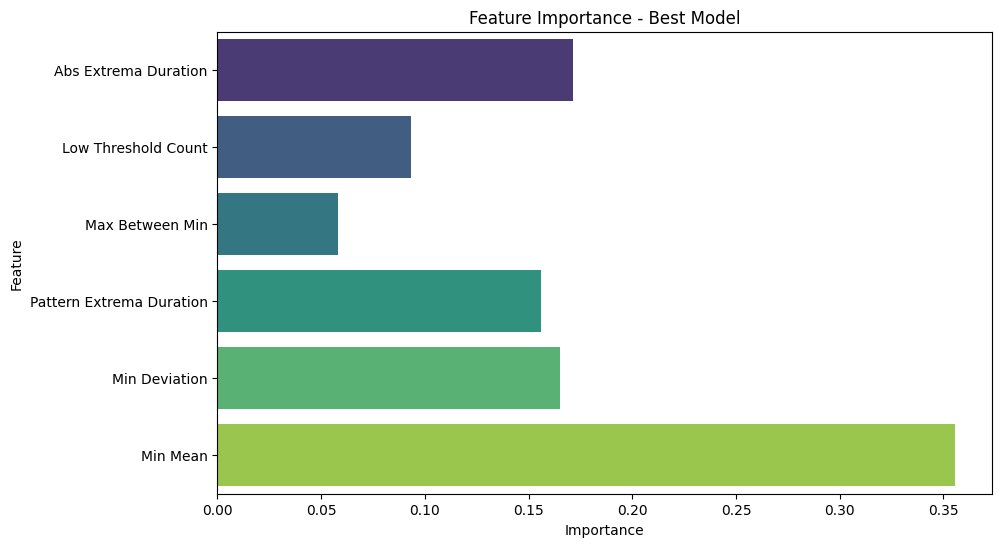

In [ ]:
if hasattr(best_model, 'feature_importances_'):
    feature_importances = best_model.feature_importances_
    features = features_df.columns
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances,
                y=features,
                palette='viridis',
                hue=features,
                legend=False)
    
    plt.title("Feature Importance - Best Model")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()
else:
    print("The best model does not provide feature importances.")

c:\Users\walte\anaconda3\envs\double-bottom-detection-ml\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


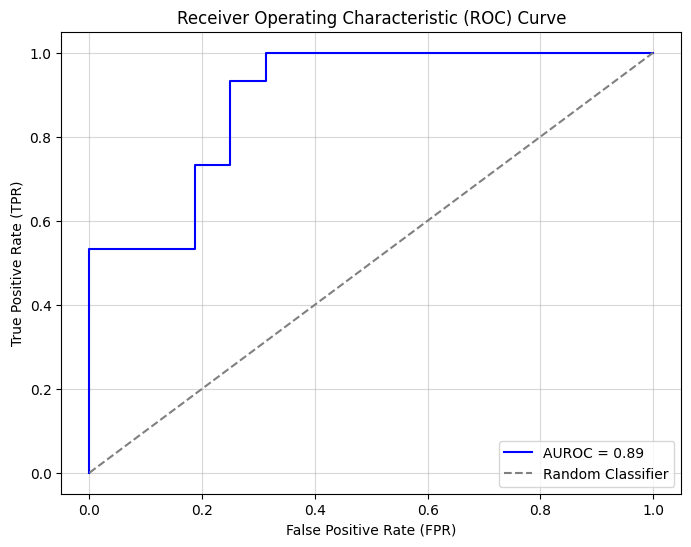

AUROC Score: 0.89


In [59]:
if hasattr(best_model, "predict_proba"):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_pred_proba = best_model.decision_function(X_test)
else:
    raise AttributeError("The selected model does not support probability or decision function.")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUROC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.show()

print(f"AUROC Score: {auc_score:.2f}")

**Conclusions**

Based on the ROC curve and the AUROC score of 0.89, the model seems to perform well in distinguishing between the two classes. The Receiver Operating Characteristic (ROC) curve is plotting the True Positive Rate (TPR) against the False Positive Rate (FPR), and the closer the curve is to the top-left corner, the better the model.

An AUROC score of 0.89 indicates a very good model, as it’s quite close to the ideal score of 1. This suggests the classifier is good at distinguishing between the two classes (No Pattern and Double Bottom).

The dashed line represents a random classifier (a model that makes predictions by chance), which would result in an AUROC score of 0.5. Since your model's curve is far from this dashed line and closer to the top-left corner, it shows that the model has learned to classify the data better than random guessing.

Overall, the high AUROC and the clear separation in the ROC curve indicate that the model has strong discriminative power and performs well on the task.

## Overall Conclusions:

- Good overall performance:

The model achieves robust performance with regularized parameters, which shows that it is avoiding excessive overfitting.
The 6.67% difference between training and validation is acceptable in complex models such as Random Forest.

- Small overfitting:

The gap indicates that the model could still benefit from more data or additional adjustments, such as:

1. Increase *min_samples_leaf* or *min_samples_split* to further reduce overfitting.

2. Explore slightly lower *max_depth* or use *pruning* techniques.

3. Introduce a stricter cross-validation method or test higher cv_splits.

- Unnecessary scaling:

For a RandomForestClassifier, the use of StandardScaler is not indispensable, since random forests are not affected by the scale of the data. However, if your pipeline involves other scale-sensitive models (such as SVM or linear regressions), the scaler is useful.